<a href="https://www.kaggle.com/code/mexwell/cirrhosis-patient-survival-eda-and-ensemble?scriptVersionId=153695446" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<p style="font-family: Verdana; letter-spacing: 2px; color:#000000; font-size:300%; padding: 0px; text-align:center;"><b>Cirrhosis Patient Survival Prediction</b><br>Detailed EDA and Voting Ensemble</p>
<center>
<img src="https://surgery.ucsf.edu/media/9244862/Liver_Cirrhosis.png" width=600/>
</center>

# Introduction
Cirrhosis is a late stage of scarring (fibrosis) of the liver caused by various forms of liver diseases and conditions, such as chronic alcoholism, hepatitis B and C, fatty liver disease, and certain genetic disorders. Over time, healthy liver tissue is replaced by scar tissue, which can affect liver function and potentially lead to liver failure.

Symptoms of cirrhosis might not appear until the liver damage is extensive. When symptoms do occur, they can include fatigue, weakness, easy bruising, loss of appetite, weight loss, jaundice (yellowing of the skin and eyes), swelling in the legs and abdomen, itching, and confusion.

In this notebook I will predict the patient survival diagnosed with cirrhosis. 

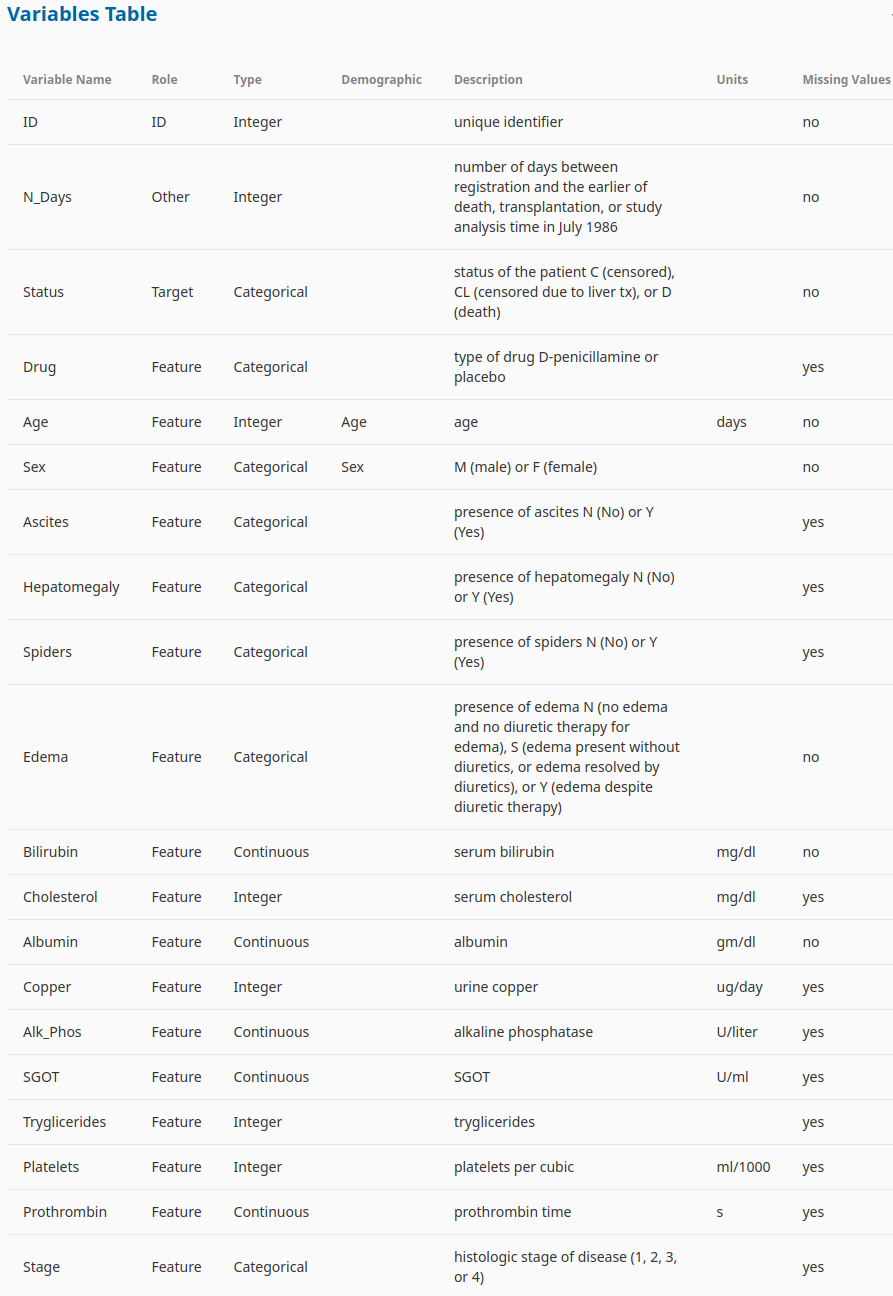

*[Original Source](https://www.kaggle.com/datasets/joebeachcapital/cirrhosis-patient-survival-prediction)*

In [ ]:
!pip install -q scikit-lego
!wget https://raw.githubusercontent.com/h4pZ/rose-pine-matplotlib/main/themes/rose-pine-dawn.mplstyle -P /tmp

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder
from sklearn import set_config
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.base import clone
from sklearn.preprocessing import FunctionTransformer, StandardScaler, PowerTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, roc_curve, confusion_matrix, log_loss
import warnings

import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option('display.max_columns',None)

In [ ]:
plt.style.use('ggplot')

# Get Data
Okay so let´s first load our data and get a general overview about it.

In [ ]:
train = pd.read_csv('/kaggle/input/playground-series-s3e26/train.csv', index_col='id')
test = pd.read_csv('/kaggle/input/playground-series-s3e26/test.csv', index_col='id')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s3e26/sample_submission.csv')
original = pd.read_csv('/kaggle/input/cirrhosis-patient-survival-prediction/cirrhosis.csv', index_col='ID')

# Descriptive Statistics

## Train

In [ ]:
print(train.shape)
train.describe().style.background_gradient('Reds')

## Test

In [ ]:
print(test.shape)
test.describe().style.background_gradient('Reds')

## Original

In [ ]:
print(original.shape)
original.describe().style.background_gradient('Reds')

# Missing Values

In [ ]:
print('Number of missing values in train set')
train.isnull().sum()

In [ ]:
print('Number of missing values in test set')
test.isnull().sum()

In [ ]:
print('Number of missing values in original set')
original.isnull().sum()

In [ ]:
num_features = train._get_numeric_data().columns
cat_features = train.drop(num_features, axis=1)

<div style="border-radius:10px; border:#484366 solid; padding: 15px; background-color: #FFEBCC; font-size:100%; text-align:left">

<h3 align="left"><font color='#484366'>💡 Insights</font></h3>

* No missing values in train and test set
* Almost all columns in the original dataset have missing data
* Many data type missmatches when comparing the data types with the description from the original set
* Train set contains 7905 observations with 18 features and the target variable Status
* Test set contains 5271 observations with 18 features

# Exploratory Data Analysis
## Target Distribution

In [ ]:
sns.countplot(data=train, x='Status', palette='Set1')
plt.title('Target Distribution Train Set')
plt.show();
C, D, CL = train['Status'].value_counts()
print(f'Number of patients with status C: {C}({round(C / len(train) * 100, 2)}%)')
print(f'Number of patients with status D: {D} ({round(D / len(train) * 100, 2)}%)')
print(f'Number of patients with status CL: {CL} ({round(CL / len(train) * 100, 2)}%)')
print('')

In [ ]:
sns.countplot(data=original, x='Status', palette='Set1')
plt.title('Target Distribution Original Set')
plt.show();
C, D, CL = original['Status'].value_counts()
print(f'Number of patients with status C: {C}({round(C / len(original) * 100, 2)}%)')
print(f'Number of patients with status D: {D} ({round(D / len(original) * 100, 2)}%)')
print(f'Number of patients with status CL: {CL} ({round(CL / len(original) * 100, 2)}%)')
print('')

## Numeric Feature Distribution

In [ ]:
fig, ax = plt.subplots(6, 2, figsize = (20, 20), dpi=300)
ax = ax.flatten()
for idx,column in enumerate(num_features):
    sns.kdeplot(data=train, x=column, ax=ax[idx])
    sns.kdeplot(data=test, x=column, ax=ax[idx])
    sns.kdeplot(data=original, x=column, ax=ax[idx])
    
    ax[idx].set_title(f'{column} Distribution', size = 14)
    ax[idx].set_xlabel(None)
    plt.tight_layout()

fig.suptitle('Distribution of Numeric Features', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test', 'Original Train'])
plt.tight_layout()
plt.subplots_adjust(top=0.9)

## Categorical Feature Distribution

In [ ]:
fig, ax = plt.subplots(7, 2, figsize=(20,20), dpi=300)
for idx, column in enumerate(cat_features):
    try:
        sns.countplot(data=train, y=column, ax=ax[idx][0], palette='Set1')
        sns.countplot(data=test, y=column, ax=ax[idx][1], palette='Set1')
        ax[idx][0].yaxis.label.set_size(20)
        ax[idx][0].xaxis.label.set_size(20)
        ax[idx][0].set_xlabel('Count in Train Set')
        ax[idx][1].yaxis.label.set_size(20)
        ax[idx][1].xaxis.label.set_size(20)
        ax[idx][1].set_xlabel('Count in Test Set')
    except:
        pass
    
fig.suptitle('Distribution of Categorical Features', fontsize = 24, fontweight = 'bold')
plt.tight_layout()
plt.subplots_adjust(top=0.9)

## Correlation

In [ ]:
corr = train[num_features].corr().round(2)
mask = np.zeros_like(corr, dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Correlation Matrix', fontsize=18)
plt.tight_layout()

<div style="border-radius:10px; border:#484366 solid; padding: 15px; background-color: #FFEBCC; font-size:100%; text-align:left">

<h3 align="left"><font color='#484366'>💡 Insights</font></h3>

* Target distribution is highly imbalanced, only around 5% of the patients are labeled as CL
* Train and Testset have similar distribution
* Since the original data set has a different distribution than train and test, as well as many missing vlaues, it is not used. 
* No high negative or positive correlation within the numerical features

# Preprocessing
I won´t transform the data types to their original form. So the first thing to do is to one-hot encode the label. 

In [ ]:
y = train['Status']
X = train.drop(columns=['Status'])

In [ ]:
encoder = LabelEncoder().fit(y)
y = encoder.transform(y)

In [ ]:
seed = 1702
np.random.seed(seed)
skf = StratifiedKFold(random_state=seed, shuffle=True)

# Cross Validation
Now we can start evaluating the performance of our model. 

In [ ]:
score_list, oof_list = pd.DataFrame(), pd.DataFrame()

models = [
    ('log', LogisticRegression(random_state = seed, max_iter = 1000000, class_weight = 'balanced')),
    ('lda', LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB()),
    ('bnb', BernoulliNB()),
    ('rf', RandomForestClassifier(random_state = seed)),
    ('et', ExtraTreesClassifier(random_state = seed)),
    ('xgb', XGBClassifier(random_state = seed)),
    ('lgb', LGBMClassifier(random_state = seed)),
    ('dart', LGBMClassifier(random_state = seed, boosting_type = 'dart')),
    ('cb', CatBoostClassifier(random_state = seed, verbose = 0)),
    ('gb', GradientBoostingClassifier(random_state = seed)),
    ('hgb', HistGradientBoostingClassifier(random_state = seed)),
]

In [ ]:
for (label, model) in models:
    score_list[label] = cross_validation_score(estimator=model,
                                                                cv=skf,
                                                                label=label)

In [ ]:
plt.figure(figsize = (8, 4), dpi = 300)
sns.barplot(data = score_list.reindex((-1 * score_list).mean().sort_values().index, axis = 1), orient = 'h')
plt.title('Score Comparison', weight = 'bold', size = 18)
plt.show()

As we can see above, GradientBoostingClassifier, LGBMClassifier and CatBoostClassifier are the TOP3 models based on the score.

# Voting

So let´s try to build a `VotingClassifier` for our final model based on the three best models. 

In [ ]:
gb_model = GradientBoostingClassifier(random_state=seed)
dart_model = LGBMClassifier(random_state = seed, boosting_type = 'dart')
cb_model = CatBoostClassifier(random_state = seed, verbose = 0)
voting = VotingClassifier(estimators=[
    ('gb', gb_model),
    ('dart', dart_model),
    ('cb', cb_model)
], voting='soft')

In [ ]:
_ = cross_validation_score(estimator=voting, cv=skf, label='voter')

# Prediction and Submission
Finally, let´s train our chosen model on the whole train dataset and run the prediction on the test set. 

In [ ]:
X = pd.get_dummies(X)

In [ ]:
voting.fit(X,y)

In [ ]:
submission = test.copy()
submission = pd.get_dummies(submission)

In [ ]:
preds = voting.predict_proba(submission)

In [ ]:
submission['Status_C'] = preds[:,0]
submission['Status_CL'] = preds[:,1]
submission['Status_D'] = preds[:,2]

In [ ]:
submission[['Status_C', 'Status_CL', 'Status_D']]

In [ ]:
submission[['Status_C', 'Status_CL', 'Status_D']].to_csv('submission.csv')

**Thank you for reading to the end. I would appreciate an upvote if you find this notebook useful 🤝**